In [1]:
#Import libraires
import processing
import externalize as ext
import flowcode
import final_AE

import torch
import pandas as pd
import numpy as np
import os

### This section of notebook is same as the contents in the corresponding workflow.py file, training the Normalzing Flow is recommended to be done using the script as it takes a lot of time.

In [2]:
#Filename for a given run
filename = "random"

In [3]:
#Initiate the processor
mpc = processing.Processor_cond()

In [4]:
#Load raw data, this loads the data from the files and processes it to the correct format
Galaxies_raw = mpc.get_data(r"/export/home/ksampath/my_venv/Dataset/galaxy_numpy_data")

In [5]:
#Clean data with specific algorithm, set percentile1 and percentile2 to 98%
Galaxies_cleaned, Galaxies_removed, Stars_removed = mpc.constraindata(Galaxies_raw, percentile1=98, percentile2=98, N_min=500)

Cut out 3 of 83 galaxies, 1342074 of 33792677 stars (~4%).


In [6]:
#Pring the galaxies removed and remove these galaxies from main dataset of images before training the AE
#Remove the above galaxies from the dataset before training autoencoder model
path = r"/export/home/ksampath/my_venv/26-07/Dataset/galaxy_image_data"
gal_rem_l = []
for galaxy_dict in Galaxies_removed:
    file_name = path+"/"+ galaxy_dict["galaxy"]["NIHAO_id"] + ".png"
    try: 
        os.remove(file_name)
        print("File removed")
    except:
        print("File not present")
    gal_rem_l.append(galaxy_dict["galaxy"]["NIHAO_id"])
print(gal_rem_l)
#Check length before proceeding
len(os.listdir(path))

File not present
File not present
File not present
['g5.22e09', 'g7.34e09', 'g9.26e09']


80

In [7]:
"""#Call and train model
path = r"/export/home/ksampath/my_venv/26-07/Dataset/galaxy_image_data"
final_AE.AutoEncoder(path)"""

'#Call and train model\npath = r"/export/home/ksampath/my_venv/26-07/Dataset/galaxy_image_data"\nfinal_AE.AutoEncoder(path)'

In [ ]:
#Sorting galaxies based on NIHAO ID
Galaxies_sorted = sorted(Galaxies_cleaned, key=lambda x: x['galaxy']['NIHAO_id'])

#Resetting the index for dataframe
for i in Galaxies_sorted:
    i["stars"].reset_index(drop = True, inplace = True)

In [10]:
#Chose a subset of the data
#1. Define conditions to be used
#Done by supplying a function, that computes conditions from a galaxy (dict as above) and returns them with condition names (dict or DataFrame)
cond_fn = ext.cond_M_stars_2age_avZ

#2. Name the components to be used
#Here ignore a stars mass as they are all equal due to simulation restrictions
comp_use = ["x", "y", "z", "vx", "vy", "vz", "Z", "feh", "ofe", "age"]

#3. Define the subset to be used (MWs, all, etc.)
import random
# Exclude specific numbers from the random sample
exclude = {66, 20, 33, 48, 5}

# Generate a list of 75 unique random numbers between 1 and 81 excluding the specified numbers
unique_numbers = random.sample([num for num in range(1, 81) if num not in exclude], 75)

#use_fn_view = ext.construct_all_galaxies_leavout("id", unique_numbers)
use_fn_view = ext.construct_all_galaxies_leavout("id",[])
Galaxies = mpc.choose_subset(Galaxies_sorted, use_fn = use_fn_view, cond_fn=cond_fn, comp_use=comp_use)

#Subset to train on (e.g. all galaxies, leavout 5 as validation set):
leavout_idices = [66, 20, 33, 48, 5]
use_fn_train = ext.construct_all_galaxies_leavout("id", leavout_idices)
Galaxies_train = mpc.choose_subset(Galaxies_sorted, use_fn = use_fn_train, cond_fn=cond_fn, comp_use=comp_use)

Chose 80 of 80 galaxies.
Chose 75 of 80 galaxies.


In [11]:
Galaxies_train

[{'stars':               x         y         z         vx         vy         vz  \
  0      0.392172 -0.719005 -0.299138 -47.231960  28.440284  58.295642   
  1     -1.647008 -0.718879  0.289526  -3.064232  70.937761  24.436441   
  2      9.699705  0.846876 -0.269296 -78.930699  26.252665   2.403746   
  3     -5.629874  1.956100 -0.622473 -36.425172 -32.820192   8.264200   
  4     -2.467471  2.682117 -0.003698  11.895149  17.662819  24.949269   
  ...         ...       ...       ...        ...        ...        ...   
  68986  7.026439  4.460032 -1.684753 -47.825576  25.260321  19.308997   
  68987  7.178724  4.321965 -1.628008 -20.850050  10.761419  14.985289   
  68988  7.304803  4.282179 -1.605336 -17.396547  10.111863  12.951498   
  68989  7.161064  4.299092 -1.702954 -25.431963   8.147239  13.437631   
  68990  6.981972  4.364196 -1.724685 -71.331975  15.396304  27.988387   
  
                    Z       feh       ofe        age  
  0      5.914080e-07 -5.221701  0.708509  13

In [12]:
#Add latent space to the final list of parameters
import os
latent_space_folder = r"/export/home/ksampath/my_venv/26-07/final_latent_spaces"   #REPLACE WITH PATH TO LATENT SPACE FOLDER

for galaxy_dict in Galaxies_train :
    galaxy_id = galaxy_dict['galaxy']['NIHAO_id']  
    
    latent_space_file = os.path.join(latent_space_folder, f'{galaxy_id}_latent.npy')
    latent_space = list(np.load(latent_space_file))

    for i in range(0,16):
        galaxy_dict['parameters'][f'lv{i+1}'] = latent_space[i]

Galaxies_train

[{'stars':               x         y         z         vx         vy         vz  \
  0      0.392172 -0.719005 -0.299138 -47.231960  28.440284  58.295642   
  1     -1.647008 -0.718879  0.289526  -3.064232  70.937761  24.436441   
  2      9.699705  0.846876 -0.269296 -78.930699  26.252665   2.403746   
  3     -5.629874  1.956100 -0.622473 -36.425172 -32.820192   8.264200   
  4     -2.467471  2.682117 -0.003698  11.895149  17.662819  24.949269   
  ...         ...       ...       ...        ...        ...        ...   
  68986  7.026439  4.460032 -1.684753 -47.825576  25.260321  19.308997   
  68987  7.178724  4.321965 -1.628008 -20.850050  10.761419  14.985289   
  68988  7.304803  4.282179 -1.605336 -17.396547  10.111863  12.951498   
  68989  7.161064  4.299092 -1.702954 -25.431963   8.147239  13.437631   
  68990  6.981972  4.364196 -1.724685 -71.331975  15.396304  27.988387   
  
                    Z       feh       ofe        age  
  0      5.914080e-07 -5.221701  0.708509  13

In [13]:
#The flow should be trained in normalized coordinates
#Also we want e.g. total stellar mass to be learned in log

#M_stars should be learned in log
LOG_LEARN = ["M_stars"]

#Define the transformations to be used
transformations = (np.log10, )
#Define the manes affected by the transformations (i.e. components of trf_names[i] are supplied to transformations[i])
trf_names = (LOG_LEARN, )
#Define the inverse transformations (these are applied to the model output)
transformations_inv = (lambda x: 10**x, )
#Define the logdets of the transformations needed if the pdf is to be computed
logdets = (ext.logdet_log10,)

#Now diststack will format the data to the correct format for the flow (one array of iid samples)
#Essentially, it will stack all stars of all galaxies together and apend the conditions of the corresponding to each star
#Data_to_flow will then normalize the data and apply the transformations
#The returned data is to be used for training directly
#IMPORTANT: Do not modify the returned data in any way:
#The processor remembers e.g. the order of the components and will assume those when obtaining a sample from the flow and renaming them
#Also remember e.g. (f°g)^-1 = g^-1 ° f^-1
#so if you apply a transformation to the data, you would need to apply the inverse transformation to the flow output before the processor can use it
#which is not possible as the processor directly applies the inverse transformation to the flow output
Data_flow = mpc.Data_to_flow(mpc.diststack(Galaxies_train), transformations, trf_names, transformations_inv, transformation_logdets=logdets)

In [14]:
#Choose deviceuda"
device = torch.device("cuda")

In [15]:
#Hyperparameters of the flow
LAYER_TYPE = flowcode.NSF_CL2
N_LAYERS = 16
COND_NAMES = mpc.cond_names["galaxy"]
DIM_COND = len(COND_NAMES)
DIM_NOTCOND = 10
SPLIT = 0.5
K = 10
B = 3
BASE_NETWORK = flowcode.MLP
BASE_NETWORK_N_LAYERS = 4
BASE_NETWORK_N_HIDDEN = 128
BASE_NETWORK_LEAKY_RELU_SLOPE = 0.2

SPLIT = {"split":SPLIT} if LAYER_TYPE == flowcode.NSF_CL else {}
print(DIM_COND,DIM_NOTCOND)

20 10


In [16]:
#Training hyperparameters
N_EPOCHS = 12
INIT_LR = 0.00009
GAMMA = 0.998
BATCH_SIZE = 1024

In [17]:
#Instantiate the model
model = flowcode.NSFlow(N_LAYERS, DIM_NOTCOND, DIM_COND, LAYER_TYPE, **SPLIT, K=K, B=B, network=BASE_NETWORK, network_args=(BASE_NETWORK_N_HIDDEN,BASE_NETWORK_N_LAYERS,BASE_NETWORK_LEAKY_RELU_SLOPE))
model = model.to(device)

In [21]:
#Hyperparameters of the flow
LAYER_TYPE = flowcode.NSF_CL2
N_LAYERS = 20
COND_NAMES = mpc.cond_names["galaxy"]
DIM_COND = len(COND_NAMES)
DIM_NOTCOND = 10
SPLIT = 0.5
K = 10
B = 3
BASE_NETWORK = flowcode.MLP
BASE_NETWORK_N_LAYERS = 4
BASE_NETWORK_N_HIDDEN = 128
BASE_NETWORK_LEAKY_RELU_SLOPE = 0.2

SPLIT = {"split":SPLIT} if LAYER_TYPE == flowcode.NSF_CL else {}

#Training hyperparameters
N_EPOCHS = 15
INIT_LR = 0.00009
GAMMA = 0.995
BATCH_SIZE = 1024

#Instantiate the model
model = flowcode.NSFlow(N_LAYERS, DIM_NOTCOND, DIM_COND, LAYER_TYPE, **SPLIT, K=K, B=B, network=BASE_NETWORK, network_args=(BASE_NETWORK_N_HIDDEN,BASE_NETWORK_N_LAYERS,BASE_NETWORK_LEAKY_RELU_SLOPE))
model = model.to(device)

In [18]:
folder_to_save = ""

In [19]:
""""#train directly in notebook/current process
import time
train_loss_saver = []
start = time.perf_counter()
flowcode.train_flow(model, Data_flow, COND_NAMES, N_EPOCHS, folder_to_save, lr=INIT_LR, batch_size=BATCH_SIZE, loss_saver=train_loss_saver, gamma=GAMMA)
end = time.perf_counter()
torch.save(model.state_dict(), f"saves/{filename}.pth")
np.save(f"saves/loss_{filename}.npy",np.array(train_loss_saver+[end-start]))"""

'"#train directly in notebook/current process\nimport time\ntrain_loss_saver = []\nstart = time.perf_counter()\nflowcode.train_flow(model, Data_flow, COND_NAMES, N_EPOCHS, folder_to_save, lr=INIT_LR, batch_size=BATCH_SIZE, loss_saver=train_loss_saver, gamma=GAMMA)\nend = time.perf_counter()\ntorch.save(model.state_dict(), f"saves/{filename}.pth")\nnp.save(f"saves/loss_{filename}.npy",np.array(train_loss_saver+[end-start]))'

### Once training is done, we can retireve the saved checkpoint for sampling and inference

In [22]:
#Load model from checkpoint
model.load_state_dict(torch.load(r"/export/home/ksampath/my_venv/26-07/checkpoints_cnf3/checkpoint_91.pth")) #REPLACE WITH PATH TO MODEL
loss_results = np.load(r"/export/home/ksampath/my_venv/26-07/checkpoints_cnf3/losses_91.npy")
loss_results, tot_time = loss_results[:-1], loss_results[-1]/60

In [23]:
#Add latent space as parameters
latent_space_folder = r"/export/home/ksampath/my_venv/26-07/final_latent_spaces"   #REPLACE WITH PATH TO LATENT SPACE FOLDER

for galaxy_dict in Galaxies :
    galaxy_id = galaxy_dict['galaxy']['NIHAO_id']  
    
    latent_space_file = os.path.join(latent_space_folder, f'{galaxy_id}_latent.npy')
    latent_space = list(np.load(latent_space_file))

    for i in range(0,16):
        galaxy_dict['parameters'][f'lv{i+1}'] = latent_space[i]

Galaxies

[{'stars':               x         y         z         vx         vy         vz  \
  0      0.392172 -0.719005 -0.299138 -47.231960  28.440284  58.295642   
  1     -1.647008 -0.718879  0.289526  -3.064232  70.937761  24.436441   
  2      9.699705  0.846876 -0.269296 -78.930699  26.252665   2.403746   
  3     -5.629874  1.956100 -0.622473 -36.425172 -32.820192   8.264200   
  4     -2.467471  2.682117 -0.003698  11.895149  17.662819  24.949269   
  ...         ...       ...       ...        ...        ...        ...   
  68986  7.026439  4.460032 -1.684753 -47.825576  25.260321  19.308997   
  68987  7.178724  4.321965 -1.628008 -20.850050  10.761419  14.985289   
  68988  7.304803  4.282179 -1.605336 -17.396547  10.111863  12.951498   
  68989  7.161064  4.299092 -1.702954 -25.431963   8.147239  13.437631   
  68990  6.981972  4.364196 -1.724685 -71.331975  15.396304  27.988387   
  
                    Z       feh       ofe        age  
  0      5.914080e-07 -5.221701  0.708509  13

In [24]:
#Get a sample from the flow
#use_GPUs = []
import time
start = time.perf_counter()
#Set a condition for the sample
#Here, sample back all galaxies
#I.e. Condition = all galaxy parameters as often as there are stars in the galaxy in a known order
condition = mpc.diststack(Galaxies)[COND_NAMES]

#Get sample with sample_Conditional
#This will automatically:
#1. Normalize the condition (using reproduce_normalization)
#2. Sample from the flow

#Denormalize the sample with sample_to_Data
flow_sample = mpc.sample_to_Data(mpc.sample_Conditional(model, condition, split_size=int(6e5)))

#To revert to a galaxy interpretation we need to specify the number of stars belonging in each galaxy
#Again, we use the same as in the data
N_stars_galaxies = mpc.get_array(Galaxies, "galaxy" ,"N_stars")
#or
N_stars_galaxies = np.array([len(galaxy["stars"]) for galaxy in Galaxies])

#Convert sample to galaxy interpretation
flow_sample = mpc.galaxysplit(flow_sample, N_stars_galaxies)

#However this is now list of pandas dataframes, not a list of dictionaries as the original data
#we can convert it back to a list of dictionaries
flow_sample = [{"stars":galaxy_stars} for galaxy_stars in flow_sample]
#In our special case, we can also reinsert the galaxy information that we know from the original data
#This is of course not possible in general
for galaxy_flow, galaxy in zip(flow_sample, Galaxies):
    galaxy_flow["galaxy"] = galaxy["galaxy"]

#Similarly, one can also reinsert the conditions
for galaxy_flow, galaxy in zip(flow_sample, Galaxies):
    galaxy_flow["parameters"] = galaxy["parameters"]

#Format in minutes and seconds
print(f"Time to sample: {int((time.perf_counter()-start)/60)} minutes and {int((time.perf_counter()-start)%60)} seconds")

/export/home/ksampath/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Time to sample: 11 minutes and 44 seconds


In [25]:
"""
Implements functions to visualize the results of the flow.
Mainly:
- Comparing two galaxies with cornerplot_hist or get_result_plots
- Plotting all galaxies with plot_conditional_2 and plot_conditional_histograms
"""
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d
import itertools
import scipy.stats
from scipy.interpolate import interp1d

standard_zoomout = 1.2
comp_names = "xyz"

def _get_hist_bins(x, y, gridsize, perserve_aspect, standard_zoomout):
    """Get right bins for 2D histogram in corner plot"""
    if perserve_aspect:
        min_x = min(x.min(), y.min())
        max_x = max(x.max(), y.max())
        min_y = min_x
        max_y = max_x
    else:
        min_x = x.min()
        max_x = x.max()
        min_y = y.min()
        max_y = y.max()

    x_bins = np.linspace(min_x*standard_zoomout, max_x*standard_zoomout, gridsize)
    y_bins = np.linspace(min_y*standard_zoomout, max_y*standard_zoomout, gridsize)
    return x_bins, y_bins

def _get_global_vmin_vmax(results):
    """Get global vmin and vmax for a list of results in cornerplot_hist"""
    vmin_data = -np.inf
    vmax_data = np.inf
    vmin_flow = -np.inf
    vmax_flow = np.inf
    
    for (i, j), result in np.ndenumerate(results):
        if j>i and result is not None:
            vmin_data = np.minimum(vmin_data, np.min(result["data"][0]))
            vmax_data = np.maximum(vmax_data, np.max(result["data"][0]))
            vmin_flow = np.minimum(vmin_flow, np.min(result["flow"][0]))
            vmax_flow = np.maximum(vmax_flow, np.max(result["flow"][0]))
    return vmin_data, vmax_data, vmin_flow, vmax_flow


def _share_cp_axis(ax_data, ax_flow, ind_x, ind_y, axs, flip_flow):
    if flip_flow:
        #Now the flow is in the same direction as the data so we can share axes
        if ind_x != 0:
            ind_take = 0 if ind_y != 0 else 1
            ax_data.sharey(axs[ind_y][ind_take])
        #Same for x axis of data
        max_ind = len(axs)-1
        if ind_y != max_ind:
            ind_take = max_ind #also share with the diagonal
            ax_data.sharex(axs[ind_take][ind_x])
        #Same for y axis of flow
        ax_flow.sharey(ax_data)
        ax_flow.sharex(ax_data)
        
    else:
        if ind_x != 0:
            ind_take = 0 if ind_y != 0 else 1
            ax_data.sharey(axs[ind_y][ind_take])
        if ind_y != 0:
            ind_take = 0 if ind_x != 0 else 1
            ax_flow.sharey(axs[ind_x][ind_y])

def _apply_manual_cuts(manual_cut_dict, name_x, data_x, name_y, data_y):
    #Args is name, value, name, value, ...
    lower_x, upper_x = manual_cut_dict.get(name_x, (-np.inf, np.inf))
    lower_y, upper_y = manual_cut_dict.get(name_y, (-np.inf, np.inf))
    is_in_x = (data_x >= lower_x) & (data_x <= upper_x)
    is_in_y = (data_y >= lower_y) & (data_y <= upper_y)
    is_in = is_in_x & is_in_y
    data_x = data_x[is_in]
    data_y = data_y[is_in]
    return data_x, data_y

    

x_and_v = list(itertools.chain(itertools.product(["x","y","z"],["x","y","z"]),itertools.product(["vx","vy","vz"],["vx","vy","vz"])))
def cornerplot_hist(galaxy_true, galaxy_flow=None, names_to_print=None, color="individual", color_pass="local", grid_pass=False, perserve_aspect_grid=x_and_v, flip_flow=True, save_fig=False, manual_cut_dict=None):
    """
    Make a corner plot of the data and flow, with KDE plots on the diagonal and 2D histograms on the off-diagonal. One side of the diagonal is data, the other is flow.

    Parameters
    ----------

    data_true : pd.DataFrame
        The (true) galaxy data to plot contains the labeled components.

    data_flow : pd.DataFrame, optional, default: None
        The flow sample for the galaxy, same format as data_true. If None, only the data is plotted.

    names_to_print : list of str, optional, default: None
        The names for the labels of the components. If None, the names are taken from the columns of data_true.

    color : {"individual", "global"}, optional, default: "individual"
        Whether the plots in one corner should be colored individually or with the same color scale.
    
    color_pass : {"first", "local", "global"}, optional, default: "local"
        Whether the color scale should be set by the data ("first"), the data or flow in the repsective corner ("local") or the data and flow in the whole plot ("global").

    grid_pass : bool, optional, default: False
        Wheather to use the same grid used for the data for the flow as well, or recalculte the grid for the flow.

    perserve_aspect_grid : list of tuples of str, optional, default: x_and_v
        The cornerplots for which an aspect ratio should be preserved. Each tuple is a pair of component names of the respective plot.

    flip_flow : bool, optional, default: True
        Whether to flip the flow plots in the off-diagonal, such that the flow is plotted in the same direction as the data.
        This will also share all axes between the data and flow plots and include new labels for the flow plots.

    save_fig : bool or str, optional, default: False
        Path to save the figure to. If False, the figure is not saved.

    manual_cut_dict : dict, optional, default: None
        Dictionary containing the manual cuts for the data. The keys are the names of the components, the values are tuples of the form (min, max).
        E.g. {"[Fe/H]":(-1,1)} will cut the data in the [Fe/H] component at -1 and 1.
    """
    label_kwargs = {"fontsize":22}
    colormap = "coolwarm"
    #Check all inputs
    if color not in ["individual", "global"]:
        raise ValueError("color must be 'individual' or 'global'")
    if color_pass not in ["first", "local", "global"]:
        raise ValueError("color_pass must be 'first', 'local' or 'global'")
    
    #Highlight possibly bad choices
    if color == "global":
        print("Warning: global color scale may not be a good choice for corner plots")
    # if grid_pass:
    #     print("Warning: grid_pass may not be a good choice for corner plots")

    if manual_cut_dict is None:
        manual_cut_dict = {}

    data_names = galaxy_true.columns.to_list()
    galaxy_flow = galaxy_flow[data_names] if galaxy_flow is not None else None

    if names_to_print is None:
        names_to_print = data_names

    #First compute all results
    results = [[None for _ in data_names] for _ in data_names]
    sz = standard_zoomout
    for (ind_x, name_x), (ind_y, name_y) in itertools.product(enumerate(data_names), repeat=2):

        #Get the data
        data_x = galaxy_true[name_x].values
        data_y = galaxy_true[name_y].values
        data_x, data_y = _apply_manual_cuts(manual_cut_dict, name_x, data_x, name_y, data_y)
        if galaxy_flow is not None:
            flow_x = galaxy_flow[name_x].values
            flow_y = galaxy_flow[name_y].values
            flow_x, flow_y = _apply_manual_cuts(manual_cut_dict, name_x, flow_x, name_y, flow_y)
        
        #Decide what case we have
        if ind_x == ind_y:
            n_points_kde = 500
            #Diagonal case, use KDE

            data_kde = scipy.stats.gaussian_kde(data_x)
            x_coords_data = np.linspace(data_x.min()*sz, data_x.max()*sz, n_points_kde)
            data_kde = data_kde(x_coords_data)

            if galaxy_flow is not None:
                flow_kde = scipy.stats.gaussian_kde(flow_x)
                x_coords_flow = np.linspace(flow_x.min()*sz, flow_x.max()*sz, n_points_kde)
                flow_kde = flow_kde(x_coords_flow)
            
            else:
                flow_kde = None
                x_coords_flow = None

            results[ind_x][ind_y] = {"data":(x_coords_data, data_kde), "flow":(x_coords_flow, flow_kde), "kind":"kde"}

        elif ind_y > ind_x:
            #Off diagonal case, use 2D histogram
            gridsize = 100
            #Calculate data, and flow (ind_x>ind_y) at the same time, such that we do still have all parameters

            perserve_aspect = (name_x, name_y) in perserve_aspect_grid or (name_y, name_x) in perserve_aspect_grid

            #Data
            x_bins, y_bins = _get_hist_bins(data_x, data_y, gridsize, perserve_aspect, sz)

            data_hist = binned_statistic_2d(data_x, data_y, None, statistic="count", bins=(x_bins, y_bins))
            data_hist = list(data_hist)

            #Flow
            if galaxy_flow is not None:
                if grid_pass:
                    x_bins_flow = x_bins
                    y_bins_flow = y_bins
                else:
                    x_bins_flow, y_bins_flow = _get_hist_bins(flow_x, flow_y, gridsize, perserve_aspect, sz)

                flow_hist = binned_statistic_2d(flow_x, flow_y, None, statistic="count", bins=(x_bins_flow, y_bins_flow))
                flow_hist = list(flow_hist)
            else:
                flow_hist = None
            
            results[ind_x][ind_y] = {"data":(data_hist, x_bins, y_bins), "flow":(flow_hist, x_bins_flow, y_bins_flow), "kind":"hist"}

        else:
            pass


    #Calculate a global color scale, if needed
    if color_pass == "global":
        global_vs = _get_global_vmin_vmax(results)
    else:
        global_vs = None

    #Now plot all results
    #Share y row-wise, but ignore the diagonal as it is a different plot
    sharex = "none" if flip_flow else "col"
    fig, axs = plt.subplots(len(data_names), len(data_names), figsize=(20,20), sharex=sharex, layout = "constrained")
    for (ind_x, name_x), (ind_y, name_y) in itertools.product(enumerate(data_names), repeat=2):

        ax_data = axs[ind_y][ind_x]
        ax_flow = axs[ind_x][ind_y]

        for ax in [ax_data, ax_flow]:
                ax.set_box_aspect(1)

        if ind_y == ind_x:
            #Share x axis
            ax_data.sharex(axs[ind_x][len(data_names)-1])
            #KDE plot
            data_kde = results[ind_x][ind_y]["data"]
            flow_kde = results[ind_x][ind_y]["flow"]

            ax_data.plot(data_kde[0], data_kde[1], label="Data", color="blue")
            ax_data.fill_between(data_kde[0], data_kde[1], alpha=0.3, color="blue")
            if galaxy_flow is not None:
                ax_data.plot(flow_kde[0], flow_kde[1], label="Flow", color="orange")
                ax_data.fill_between(flow_kde[0], flow_kde[1], alpha=0.3, color="orange")

            if ind_x == 0:
                ax_data.set_ylabel("Probability\n density", **label_kwargs)
            elif ind_x == len(data_names)-1:
                ax_data.set_xlabel(names_to_print[ind_x], **label_kwargs)

            #Hide y axis labels
            plt.setp(ax_data.get_yticklabels(), visible=False)
            if ind_y != len(data_names)-1:
                plt.setp(ax_data.get_xticklabels(), visible=False)

        elif ind_y > ind_x:
            #This function will handle sharing the right axes
            _share_cp_axis(ax_data, ax_flow, ind_x, ind_y, axs, flip_flow)

            ax_data.set_facecolor(matplotlib.colormaps[colormap](0))
            ax_flow.set_facecolor(matplotlib.colormaps[colormap](0))
                
            #2D histogram
            data_hist, x_bins, y_bins = results[ind_x][ind_y]["data"]
            flow_hist, y_bins_flow, x_bins_flow = results[ind_x][ind_y]["flow"]
            #In case of flow x <-> y
            #The other indices in flow_hist are never swaped!
            if flow_hist is not None:
                if flip_flow:
                    #Again x <-> y
                    flow_hist[0] = flow_hist[0]
                    #Also x_bins and y_bins
                    x_bins_flow, y_bins_flow = y_bins_flow, x_bins_flow
                else:
                    flow_hist[0] = flow_hist[0].T


            #Get the right color scale
            if global_vs is None:
                v_min_data = data_hist[0].min()
                v_max_data = data_hist[0].max()
                if galaxy_flow is not None:
                    v_min_flow = flow_hist[0].min()
                    v_max_flow = flow_hist[0].max()
            else:
                v_min_data, v_max_data, v_min_flow, v_max_flow = global_vs

            if color_pass == "first":
                v_min_flow = v_min_data
                v_max_flow = v_max_data
            elif color_pass == "global":
                vmin = np.minimum(v_min_data, v_min_flow)
                vmax = np.maximum(v_max_data, v_max_flow)
                v_min_data, v_max_data, v_min_flow, v_max_flow = vmin, vmax, vmin, vmax
            
            #Plot the data
            im = ax_data.imshow(data_hist[0].T, origin="lower", extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]], vmin=v_min_data, vmax=v_max_data, cmap=colormap, aspect="auto")
            
            #Plot the flow, if given
            if galaxy_flow is not None:
                im = ax_flow.imshow(flow_hist[0].T, origin="lower", extent=[x_bins_flow[0], x_bins_flow[-1], y_bins_flow[0], y_bins_flow[-1]], vmin=v_min_flow, vmax=v_max_flow, cmap=colormap, aspect="auto")

            if ind_x == 0:
                ax_data.set_ylabel(names_to_print[ind_y], **label_kwargs)
            if ind_y == len(data_names)-1:
                ax_data.set_xlabel(names_to_print[ind_x], **label_kwargs)

            #Hide ticklabels except from first and last column/row
            if ind_x != 0:
                plt.setp(ax_data.get_yticklabels(), visible=False)
            if ind_y != len(data_names)-1:
                plt.setp(ax_data.get_xticklabels(), visible=False)
            
            plt.setp(ax_flow.get_yticklabels(), visible=False)
            plt.setp(ax_flow.get_xticklabels(), visible=False)
        else:
            if galaxy_flow is None:
                fig.delaxes(ax_data)

    
    #fig.suptitle("Corner plot of data and flow")
    if save_fig:
        fig.savefig(save_fig)
        #Close the figure to save memory
        plt.close(fig)
    else:
        fig.show()

        
def stat_sign_mean(x):
    """
    Function calculating the mean of the data, if the data is statistically significant i.e. if there are enough data points.
    Intended for use with binned statistics, thus returns np.nan for too few data points.

    Parameters
    ----------

    x : np.ndarray
        The data to calculate the mean for. Shape (N,)
    
    Returns
    -------

    mean : float
        The mean of the data, if there are enough data points. Otherwise np.nan
    """
    min_to_be_statistically_significant = 5
    if len(x) < min_to_be_statistically_significant or len(x) == 0:
        return np.nan
    else:
        return np.mean(x)

def residual_combined(C):
    """
    Function calculating the residuals for use a binned statistic plot.
    Reiduals are defined as the difference between the mean of the data and the mean of the flow, divided by the mean of the data.
    Assumes complex input. If the imaginary part is 0, it is assumed to be data, otherwise it is assumed to be flow.

    Parameters
    ----------

    C : np.ndarray, dtype=complex
        The data and flow samples for each bin to calculate the residuals for. Shape (N,)

    Returns
    -------

    residual : float
        The residual for the bin, to be used in the plot.
    """
    C_ = np.array(C)
    is_data = np.imag(C_) == 0
    C_data = np.real(C_[is_data])
    C_flow = np.real(C_[~is_data])
    if len(C_data)==0 or len(C_flow)==0 or len(C_data) < 5 or len(C_flow) < 5:
        return np.nan
    mean_data = np.mean(C_data)
    mean_flow = np.mean(C_flow)
    return (mean_data-mean_flow)/mean_data


def get_result_plots(data_true_, data_flow_=None, label="", format_="png", dpi=300, color_pass="local", N_unit="starsperbin"):
    """
    Plot the results of the flow for a single galaxy. Makes 4 plots:
    1. Corner plot of the data and the flow in the x,y,z plane
    2. Binned hexagonal plot in the x,y plane for  average [Fe/H], [O/Fe] and age, plots data. flow and residuals.
    3. Histograms for every component, comparing data and flow
    4. Corner plot of all components, comparing data and flow

    Parameters
    ----------

    data_true_ : np.ndarray
        Dictionary containing the data for the galaxy. Must have the keys "stars" and "galaxy".
        "stars" must be a pandas DataFrame with the columns "x", "y", "z", "vx", "vy", "vz", "Z", "feh", "ofe", "age".
        If N_unit is "massperkpc", "galaxy" dict must have the key "M_stars" with the mass of the galaxy.
    data_flow_ : np.ndarray
        Dictionary containing the flow sample for the galaxy. See data_true_.
    label : str, optional, default: ""
        Label to add to the plot titles, when saving
    format_ : str, optional, default: "png"
        Format to save the plots in
    dpi : int, optional, default: 300
        DPI resolution to save the plots in
    color_pass : str, optional, default: "local"
        Determines color scaling: "local" means that the color scale is set by and applied to the data and simply applied to flow,
        "global" means that the color scale is set by the data and flow and applied to both.
    N_unit: {"starsperbin", "starsperkpc", "massperkpc"}, default: "starsperbin"
        Unit for the density of the N plots. "starsperbin" means the number of stars per bin,
        "starsperkpc" means the number of stars per kpc^2 and "massperkpc" means the mass of stars per kpc^2.
        If "massperkpc" is chosen, the Mass parameter must be given.
    """

    #This code is fully based on old data structure, this code just functions as an adapter
    #The function could be fully rewritten to use the new data structure, but that would be a lot of work that's not really necessary

    expected_df_names = ["x", "y", "z", "vx", "vy", "vz", "Z", "feh", "ofe", "age"]
    if not all([name in data_true_["stars"].columns for name in expected_df_names]):
        raise ValueError(f"data_true_ must have the columns {expected_df_names}")
    if data_flow_ is not None and not all([name in data_flow_["stars"].columns for name in expected_df_names]):
        raise ValueError(f"data_flow_ must have the columns {expected_df_names}")
    
    if N_unit not in ["starsperbin", "starsperkpc", "massperkpc"]:
        raise ValueError("N_unit must be 'starsperbin', 'starsperkpc' or 'massperkpc'")

    if N_unit == "massperkpc":
        try:
            Mass = (data_true_["galaxy"]["M_stars"],)
            if data_flow_ is not None:
                Mass += (data_flow_["galaxy"]["M_stars"],)
        except KeyError:
            raise ValueError("Mass must be given if N_unit is 'massperkpc'")

    #Translate to tansposed numpy arrays of stars with exactly expected_df_names columns/rows and are transposed
    data_true = data_true_["stars"][expected_df_names].values.T
    if data_flow_ is None:
        data_flow = None
    else:
        data_flow = data_flow_["stars"][expected_df_names].values.T

    names = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'metals', '[Fe/H]', '[O/Fe]', 'age/Gyr']
    
    
    #2D Plots xyz corner
    ind_array = np.array([[0,1],[0,2],[1,2]])
    ax_ind_array = np.array([[0,0],[1,0],[1,1]])

    results_data = []
    results_flow = []
    vmin = np.inf
    vmax = -np.inf
    lims = []
    for (ind1, ind2) in ind_array:
        #Get grid
        sz = standard_zoomout
        max_comps = np.max(np.abs(data_true[[ind1, ind2]]))*sz
        lims.append(max_comps)
        x_bins = np.linspace(-max_comps, max_comps, 150)
        y_bins = np.linspace(-max_comps, max_comps, 150)

        #Do computation
        result_data = binned_statistic_2d(data_true[ind1], data_true[ind2], data_true[ind1], statistic="count", bins=(x_bins, y_bins))
        result_data = list(result_data)
        results_data.append(result_data)

        if data_flow is not None:
            result_flow = binned_statistic_2d(data_flow[ind1], data_flow[ind2], data_flow[ind1], statistic="count", bins=(result_data[1], result_data[2]))
            result_flow = list(result_flow)
            results_flow.append(result_flow)

        if N_unit=="starsperkpc":
            area = (result_data[1][1]-result_data[1][0])*(result_data[2][1]-result_data[2][0])
            Unit_data  = 1/area
            result_data[0] = result_data[0]*Unit_data
            if data_flow is not None:
                Unit_flow = 1/area
                result_flow[0] = result_flow[0]*Unit_flow
        elif N_unit=="massperkpc":
            area = (result_data[1][1]-result_data[1][0])*(result_data[2][1]-result_data[2][0])
            Unit_data = 1/data_true.shape[1]*Mass[0]/area
            result_data[0] = result_data[0]*Unit_data 
            if data_flow is not None:
                Unit_flow = 1/data_flow.shape[1]*Mass[1]/area
                result_flow[0] = result_flow[0]*Unit_flow
        else:
            Unit_data = 1
            Unit_flow = 1

        vmin = np.minimum(vmin, Unit_data)
        vmax = np.maximum(vmax, result_data[0].max())
        if data_flow is not None and color_pass=="global":
            vmin = np.minimum(vmin, Unit_flow)
            vmax = np.maximum(vmax, result_flow[0].max())

        #vmin = np.maximum(vmin, 1)
    #Ploting
    #Get right axes depending on if data_flow is given or not
    if data_flow is None:
        fig1, axs1 = plt.subplots(2,2, sharex = "all", sharey = "all", figsize=(8,8), layout="tight")
    else:
        fig1, axs1 = plt.subplots(2,4, sharex = "all", sharey = "all", figsize=(16,8), layout="tight")
    
    for result_data, result_flow, (ax_ind1, ax_ind2), (ind1, ind2), lim in itertools.zip_longest(results_data, results_flow, ax_ind_array, ind_array, lims):

        #First, plot the data
        ax = axs1[ax_ind1][ax_ind2]
        statistic = result_data[0]
        

        norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)

        im1 = ax.imshow(statistic.T, origin="lower", extent=[result_data[1][0], result_data[1][-1], result_data[2][0], result_data[2][-1]], cmap="magma", norm=norm)
        ax.set_xlabel(comp_names[ind1] if ax_ind1 == 1 else "")
        ax.set_ylabel(comp_names[ind2] if ax_ind2 == 0 else "")
        ax.set_facecolor(matplotlib.colormaps["magma"](0))
        ax.set_xlim(-lim,lim)
        ax.set_ylim(-lim,lim)
        ax.set_box_aspect(1)

        if data_flow is not None:
            ax.text(0.02, 0.98, "Data", ha="left", va="top", transform=ax.transAxes, color="white")
            #Now plot flow results, if given
            ax = axs1[ax_ind1][ax_ind2+2]
            statistic = result_flow[0]

            
            im1 = ax.imshow(statistic.T, origin="lower", extent=[result_flow[1][0], result_flow[1][-1], result_flow[2][0], result_flow[2][-1]], cmap="magma", norm=norm)
            ax.set_xlabel(comp_names[ind1] if ax_ind1 == 1 else "")
            ax.set_ylabel(comp_names[ind2] if ax_ind2 == 0 else "")
            ax.text(0.02, 0.98, "Flow", ha="left", va="top", transform=ax.transAxes, color="white")
            ax.set_facecolor(matplotlib.colormaps["magma"](0))
            ax.set_xlim(-lim,lim)
            ax.set_ylim(-lim,lim)
            ax.set_box_aspect(1)
    
    #Add colorbar and subtitle respecting N_unit
    fig_suptitle = f"2D {'histogram' if N_unit=='starsperbin' else ('number density' if N_unit=='starsperkpc' else 'mass density')} cornerplot."
    fig1.suptitle(fig_suptitle + " Left: data, right: sample")
    colobar_label = "" if N_unit=="starsperbin" else "1/kpc$^2$" if N_unit=="starsperkpc" else "M$_\odot$/kpc$^2$"
    fig1.colorbar(im1, ax=axs1, pad=0.03, aspect=33, shrink=1, label=colobar_label)

    plt.delaxes(axs1[0][1])
    if data_flow is not None:
        plt.delaxes(axs1[0][3])

    #plt.savefig(f"plots/Plot1{label}.{format_}", format=format_, dpi=dpi)
    plt.show()

    #Mosaic plots
    if data_flow is None:
        fig3, axs3 = plt.subplots(1,3, figsize=(12,4), sharex="all", sharey="all", layout="tight")
    else:
        fig3, axs3 = plt.subplots(3,3, figsize=(12,12), sharex="all", sharey="all", layout="tight")

    fixed_grid = False
    data_flow_dummy = data_true if data_flow is None else data_flow
    for i,(col, true, flow, name) in enumerate(zip(axs3.T, data_true[7:], data_flow_dummy[7:], names[-3:])):
        vmin = np.inf
        vmax = -np.inf
        #Data
        name = f"<{name}>"
        
        if not fixed_grid:
            sz = standard_zoomout
            max_comps = np.max(np.abs(data_true[:2]))*sz
            x_bins = np.linspace(-max_comps, max_comps, 150)
            y_bins = np.linspace(-max_comps, max_comps, 150)
        
        #Do the computation
        result_data = binned_statistic_2d(data_true[0], data_true[1], true, statistic=stat_sign_mean, bins=(x_bins, y_bins))

        if not fixed_grid:
            x_bins = result_data[1]
            y_bins = result_data[2]
            fixed_grid = True

        #Filter out the nans
        not_nan = ~np.isnan(result_data[0])
        vmin = np.minimum(vmin, result_data[0][not_nan].min())
        vmax = np.maximum(vmax, result_data[0][not_nan].max())

        #If given, do the same for flow
        if data_flow is not None:
            result_flow = binned_statistic_2d(data_flow[0], data_flow[1], flow, statistic=stat_sign_mean, bins=(x_bins, y_bins))
            if color_pass == "global":
                #Filter out the nans
                not_nan = ~np.isnan(result_flow[0])
                vmin = np.minimum(vmin, result_flow[0][not_nan].min())
                vmax = np.maximum(vmax, result_flow[0][not_nan].max())

            #And also the residuals
            x_combined = np.hstack((data_true[0], data_flow[0]))
            y_combined = np.hstack((data_true[1], data_flow[1]))
            val_combined = np.hstack((true, flow+1j))
            result_combined = binned_statistic_2d(x_combined, y_combined, val_combined, statistic=residual_combined, bins=(x_bins, y_bins))

        #Make all the plots
        #Data
        ax = col if data_flow is None else col[0]
        im2 = ax.imshow(result_data[0].T, origin="lower", extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]], vmin=vmin, vmax=vmax, cmap="coolwarm")
        ax.set_title(f"Data {name}")
        if i == 0:
            ax.set_ylabel("y")
        
        #Colorbars for flow and data
        if data_flow is None:
            fig3.colorbar(im2, ax=ax, pad=0.03, aspect=33, location="bottom", shrink=0.95)
        else:
            #Flow
            ax = col[1]
            im2 = ax.imshow(result_flow[0].T, origin="lower", extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]], vmin=vmin, vmax=vmax, cmap="coolwarm")
            ax.set_title(f"Flow sample {name}")
            if i == 0:
                ax.set_ylabel("y")
            fig3.colorbar(im2, ax=col[:2], pad=0.03, aspect=33, location="bottom", shrink=0.95)

            #Residuals
            ax = col[2]
            im2b = ax.imshow(np.real(result_combined[0]).T, origin="lower", extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]], vmin=-2, vmax=2, cmap="bwr")
            ax.set_title(f"Residual plot of {name}")
            if i == 0:
                ax.set_ylabel("y")
            ax.set_xlabel("x")
            fig3.colorbar(im2b, ax=ax, pad=0.03, aspect=33, location="bottom", shrink=0.95)

    for ax in axs3.ravel():
        ax.set_box_aspect(1)
        ax.set_xlim(-max_comps, max_comps)
        ax.set_ylim(-max_comps, max_comps)
    
    #plt.savefig(f"plots/Plot2{label}.{format_}", format=format_, dpi=dpi)
    plt.show()

    #Histograms
    fig2, axs2 = plt.subplots(4,3, figsize=(18,24))
    axs2 = axs2.ravel()
    
    axs2_crop = axs2[10*[True]+2*[False]]
    if data_flow is None:
        data_flow_dummy = data_true if data_flow is None else data_flow
    for i, (ax, true, flow, name) in enumerate(zip(axs2_crop,data_true,data_flow_dummy,names)):
        #Select larger binsize for 
        n_bins = 90 if i == 9 else 300
        ax.hist(true, bins=n_bins, histtype="step", density=True)
        if data_flow is not None:
            ax.hist(flow, bins=300, histtype="step", density=True)
        ax.set_xlabel(name)
        ax.set_ylabel("Probability density")
    
    plt.delaxes(axs2[11])
    plt.delaxes(axs2[10])
    #plt.savefig(f"plots/Plot3{label}.{format_}", format=format_, dpi=dpi)
    plt.show()
    
    #Cornerplot
    if True:
        rng = np.random.default_rng()
        data_perm = rng.permutation(data_true, axis=1)
        if data_flow is not None:
            every = data_flow.shape[1]//1000
            every = 1 if every == 0 else every
            data_corner = np.hstack((data_perm[:,::every], data_flow[:,::every]))
            data_dict = dict(zip(names, data_corner))
            hue = "Legend:"
            data_dict[hue] = np.append(np.full(data_perm[:,::every].shape[1],"Data"),np.full(data_flow[:,::every].shape[1],"Flow"))
        else:
            every = data_perm.shape[1]//1000
            every = 1 if every == 0 else every
            data_dict = dict(zip(names, data_perm[:,::every]))
            hue = None
        
        pairplot = sns.pairplot(pd.DataFrame(data_dict), corner=True, aspect=1, hue=hue, diag_kind="kde", diag_kws ={"common_norm":False}, plot_kws={"rasterized":True})
        #Increase x,y label font size:
        for ax in pairplot.fig.get_axes():
            ax.set_xlabel(ax.get_xlabel(), fontsize=20)
            ax.set_ylabel(ax.get_ylabel(), fontsize=20)
        #Same for the hue legend font size
        if hue is not None:
            pairplot._legend.set_title(pairplot._legend.get_title().get_text(), prop={"size":20})
            for t in pairplot._legend.texts:
                t.set_fontsize(20)
        #plt.savefig(f"plots/Plot4{label}.{format_}", format=format_, dpi=int(dpi//2))
        plt.show()


def loss_plot(losses, tot_time=None, savefig=None, format="png"):
    """
    Plot the loss curve, of the training.

    Parameters
    ----------

    losses : list
        List of losses, to be plotted.
    tot_time : float, optional, default: None
        Total time of the training in minutes. If None, the x-axis will be in steps, otherwise in minutes.
    savefig : str, optional, default: None
        If not None, the plot will be saved with this in the name.
    format : str, optional, default: "png"
        Format of the saved plot.
    """
    y_axis = np.array(losses)
    x_axis = np.arange(y_axis.shape[0])/1
    if tot_time:
        x_axis *= tot_time/(y_axis.shape[0]-1)
    else:
        x_axis *= 100
    
    plt.plot(x_axis, y_axis)
    plt.xlabel("time/min" if tot_time else "step")
    plt.ylabel("<loss>$_{50}$")
    plt.title("Loss curve")
    if savefig:
        plt.savefig(f"plots/loss_{savefig}.{format}", dpi=300, format=format)
    
    plt.show()


def sortgalaxies(Galaxies, Masses):
    """
    Sort galaxies by their mass.

    Parameters
    ----------

    Galaxies : list of numpy arrays
        List of galaxies to be sorted.
    Masses : np.ndarray
        Array of masses of the galaxies. Must be the same length as Galaxies.
        Note that technically Masses could be any other quantity to sort by.

    Returns
    -------

    Galaxies : list of numpy arrays
        List of galaxies sorted by their mass.
    Masses : np.ndarray
        Array of masses of the galaxies, sorted.

    """
    order = np.argsort(Masses)
    return [Galaxies[i] for i in order], Masses[order]


def xylim(Galaxies, xylim_array, comps=(0,1)):
    Galaxies_out = []
    for galaxy, lim in zip(Galaxies,xylim_array):
        include = (lim[0] <= galaxy[:,comps[0]] <= lim[1])&(lim[2] <= galaxy[:,comps[1]] <= lim[3])
        galaxy = galaxy[include]
        Galaxies_out.append(galaxy)
    return Galaxies_out

#How many galaxies to plot per page in the plot_conditional function, if a page is plotted. ormat: (n_rows, n_columns)
page_plot_layout = (10,7)#(4,3)#(10, 7) #(8, 6)
#How many galaxyies to plot per row in the plot_conditional function, if all galaxies are plotted.
n_row_all = 4

#Plot histograms for conditional data
#Histogram for each property r,z,abs(v),Z,FeH,OFe, age. The galaxies are color coded by their mass M, and in the same histogram.
#Coloring is done by sampling from a colormap in log, and the colorbar is placed at the bottom of the figure.

def plot_conditional_histograms(Galaxies, label, bins=300, cmap="viridis", log=False, manual_cut_dict=None):
    """
    Plots histograms for each property r,z,abs(v),Z,FeH,OFe, age. The galaxies are color coded by their mass M, and in the same histogram, respectivley.

    Parameters
    ----------

    Galaxies : list of dicts
        Data of the Galaxies to be plotted. List of dicts, each dict containing the properties of one galaxy.
    label : str
        Label to be used for the file name.
    bins : int, optional, dfault: 300
        Number of bins to be used for the histograms.
    cmap : str, optional, default: "viridis"
        Colormap to be sampled to color code the masses.
    log : bool, optional, default: False
        Wheather to plot the histogram in log scale.
    manual_cut_dict : dict, optional, default: None
        Dictionary containing the manual cuts to be applied to the data.
        The keys are the names of the properties, the values are tuples containing the lower and upper bound of the cut.
        This is for a better visual appearance of the plots, if tails are too long.

    Returns
    -------
    None

    Notes
    -----
    For age only a sixth of the given bins is used to reduce noise.
    """

    #Transform to old data format, see get_result_plots
    expected_df_names = ["x", "y", "z", "vx", "vy", "vz", "Z", "feh", "ofe", "age"]
    Masses = np.array([galaxy["galaxy"]["M_stars"] for galaxy in Galaxies])
    Galaxies = [galaxy["stars"][expected_df_names].values for galaxy in Galaxies]


    if manual_cut_dict is None:
        manual_cut_dict = {}

    valid_keys = ["r", "z", "v", "Z", "feh", "ofe", "age"]
    if np.isin(list(manual_cut_dict.keys()), valid_keys, invert=True).any():
        raise ValueError("Invalid key in manual_cut_dict. Keys must be r, z, v, Z, feh, ofe or age.")

    colormap = matplotlib.colormaps[cmap]
    c_norm = matplotlib.colors.LogNorm(vmin=Masses.min(), vmax=Masses.max())
    scalar_map = matplotlib.cm.ScalarMappable(norm=c_norm, cmap=colormap)

    plottables = ["r/kpc", "z/kpc", "|v|/km/s", "Z", "[Fe/H]", "[O/Fe]", "age/Gyr"]

    plot_layout = (3,3)
    figsize = (plot_layout[1]*4, plot_layout[0]*4)
    fig, axs = plt.subplots(*plot_layout, figsize=figsize, layout="constrained")
    axs = axs.ravel()

    for galaxy, mass in zip(Galaxies, Masses):
        for i, (ax, name, quantity) in enumerate(zip(axs, plottables, valid_keys)):
            if i==0:
                #Get cylindrical radius
                plot = np.sqrt(np.sum(galaxy[:,:2]**2, axis=1))
            elif i==1:
                #Get z
                plot = galaxy[:,2]
            elif i==2:
                #Get absolute velocity
                plot = np.sqrt(np.sum(galaxy[:,3:6]**2, axis=1))
            elif i>=3:
                ind_plot = i+3
                plot = galaxy[:,ind_plot]

            #Apply manual cuts
            if quantity in manual_cut_dict.keys():
                lower, upper = manual_cut_dict[quantity]
                plot = plot[(plot>=lower) & (plot<=upper)]
                
            
            ax.hist(plot, bins=int(bins/6) if i==6 else bins, color=scalar_map.to_rgba(mass), density=True, histtype="step", log=log)
            ax.set_xlabel(name)
            ax.set_ylabel("Probability density")
    for i, ax in enumerate(axs):
        if i>=len(plottables):
            fig.delaxes(ax)
    fig.suptitle("Histograms of the properties of the galaxies, colored by mass")
    cbar = fig.colorbar(scalar_map, ax=axs, shrink = 0.95, location="bottom", aspect=50, pad=0.02)
    cbar.set_label("M$_\\ast$ /M$_\odot$")
    #Minor ticks on colorbar
    cbar.ax.minorticks_on()

    #plt.savefig(f"plots/Cond_histograms_{label}.pdf", dpi=300, format="pdf")
    plt.show()


#Rewrite plot_conditional to use scipy binned_statistic_2d and plt.imshow

def plot_conditional_2(*Data_colection ,type="N", label="", show="page", scale=None, gridsize=100, cmap=None, comps=(0,1), color="global", color_pass="local", grid_pass=1, N_unit="starsperbin", global_grid = False):
    """
    Improved version of plot_conditional, uses scipy.stats.binned_statistic_2d instead of matplotlib.pyplot.hexbin allowing more consistent plots.
    Several seperate plots can be made at once and it can be chosen to share grid and coloring.

    Parameters
    ----------
    Data_colection : list of dict
        Data to be plotted. Expected form is (Galaxies1, Galaxies2, ...)
        Galaxies is a list of dicts, each containing the properties of one galaxy. Must contain "galaxy" key with "M_stars" key.
        Makes seperate plots for each tuple of Galaxies and Masses, but allows to share grid and coloring.
    type : str, optional, deault: "N"
        Type of data to be plotted. The default is "N".
        type: {"feh", "ofe", "N"}
        Determines the type of plot. "N" means a histogram of stars. "feh" or "ofe" means average [Fe/H] or [O/Fe] map, respectivley.
    label: str
        Identifing label for naming the saved file.
    show: {"page", "all"}, default: "page"
        Weather to plot a preset number of galaxies specified by page_plot_layout (default 70) to be fitting on an page and saved as pdf.
        Or to plot all galaxies in larger scale and save as png. In the former case galaxies of median masses get taken out while highest and
        lowest masses are alway plotted.
    scale: None or {"lin", "log"}, default: None
        Color scaling of the plots. ``None`` will result in linear scaling for [O/Fe] and [Fe/H] and log scaling for N.
    gridsize: int or (int, int), default: 100
        Gridsize for binned plot.
    cmap: None or str, default: None
        Colormap to be used in the plots. ``None`` means "magma" for N, and "coolwarm" otherwise.
    comps: (0 <= int < 3, 0 <= int < 3), default: (0, 1)
        Components to plot on the x and y axis, respectivley.
    color: {"global", "individual"}, default: "global"
        Weather all subplots share the same color scale, or all subplots scale on their individual maxima and minima. The former returns
        the used scale for reuse as pre-set values in another plot for better comparison.
    color_pass: {"local", "global", "first"}, default: "local"
        "global" means the max min values of the colormap are determined globally for all seperate plots.
        "local" means the max min values are determined locally for each plot.
        "first" means the max min values are determined for the first plot and used for all other plots.
    grid_pass: int, default: 1
        Number of times the grid is passed over. The grid of the first plot will be passed over grid_pass times.
    N_unit: {"starsperbin", "starsperkpc", "massperkpc"}, default: "starsperbin"
        Unit for the density of the N plots. "starsperbin" means the number of stars per bin,
        "starsperkpc" means the number of stars per kpc^2 and "massperkpc" means the mass of stars per kpc^2.
    global_grid: bool, default: False
        Weather to use a global grid for all galaxies within a plot. If False, the grid is determined for each galaxy individually.
    
    """
    #Transform to old data format, see get_result_plots
    Masses_col = [[galaxy["galaxy"]["M_stars"] for galaxy in Galaxies] for Galaxies in Data_colection]
    expected_df_names = ["x", "y", "z", "vx", "vy", "vz", "Z", "feh", "ofe", "age"]
    Data_colection = [[galaxy["stars"][expected_df_names].values for galaxy in Galaxies] for Galaxies in Data_colection]

    Data_colection = tuple(itertools.chain(*zip(Data_colection, Masses_col)))

    #Check input
    #Type
    if type not in ["feh", "ofe", "N"]:
        raise ValueError("type must be 'feh', 'ofe' or 'N'")
    #Show
    if show not in ["page", "all"]:
        raise ValueError("show must be 'page' or 'all'")
    #Scale
    if scale not in [None, "lin", "log"]:
        raise ValueError("scale must be None, 'lin' or 'log'")
    #Color
    if color not in ["global", "individual"]:
        raise ValueError("color must be 'global' or 'individual'")
    #Color_pass
    if color_pass not in ["local", "global", "first"]:
        raise ValueError("color_pass must be 'local', 'global' or 'first'")
    #N_unit
    if N_unit not in ["starsperbin", "starsperkpc", "massperkpc"]:
        raise ValueError("N_unit must be 'starsperbin', 'starsperkpc' or 'massperkpc'")

    #Standard colormap
    if cmap == None:
        cmap = "magma" if type == "N" else "coolwarm"

    #Sclaing log/lin
    if scale is None:
        scale = "log" if type == "N" else "lin"

    #Initialize
    #Data
    Galaxies_col_sorted = []
    Masses_col_sorted = []
    figsizes = []
    for Galaxies, Masses in zip(Data_colection[::2], Data_colection[1::2]):
        Galaxies_sorted, Masses_sorted = sortgalaxies(Galaxies, Masses)
        if show == "page":
            N_plot = np.prod(page_plot_layout)
            N_galaxy = len(Galaxies)
            N_leavout = N_galaxy-N_plot
            N_remain = N_galaxy-N_leavout*2
            plot_galaxy = [True]*(N_remain//2) + [True, False]*(N_leavout) + [True]*(N_remain-N_remain//2)
            Galaxies_sorted = [Galaxies_sorted[i] for i in np.arange(N_galaxy)[plot_galaxy]]
            Masses_sorted = Masses_sorted[plot_galaxy]
            plot_layout = page_plot_layout
            figsizes.append((8.27, 11.69))
        else:
            plot_layout = (-(len(Galaxies)//-n_row_all), n_row_all)
            figsizes.append((16, 4*plot_layout[0]))

        Galaxies_col_sorted.append(Galaxies_sorted)
        Masses_col_sorted.append(Masses_sorted)

    #Statistics
    if type == "N":
        statistic = "count"
    elif type == "ofe":
        statistic = "mean"
    elif type == "feh":
        statistic = "mean"

    #Iterate over all datasets of galaxies and calculate all statistics
    #Then use the results to set scalings (color, grid etc.)
    #Either use the same scalings for all datasets, or use different scalings for each dataset

    Result_col = []
    vmin_s = []
    vmax_s = []
    for i, (Galaxies_sorted, Masses_sorted) in enumerate(zip(Galaxies_col_sorted, Masses_col_sorted)):
        #A first loop over all galaxies if a global grid is used to determine the the grid extent
        if global_grid:
            global_max_comps = np.max([np.max(np.abs(galaxy[:,np.array(comps)])) for galaxy in Galaxies_sorted])
        #Initialize
        Result = []
        vmin = np.inf
        vmax = -np.inf
        #Iterate over all galaxies
        for j, (galaxy, mass) in enumerate(zip(Galaxies_sorted, Masses_sorted)):
            #Get right grid
            if i==0 or i>grid_pass:
                #Do individual grid, with quadratic bins
                sz = standard_zoomout
                max_comps = np.max(np.abs(galaxy[:,np.array(comps)])) if not global_grid else global_max_comps
                x_bins = np.linspace(-max_comps*sz, max_comps*sz, gridsize)
                y_bins = np.linspace(-max_comps*sz, max_comps*sz, gridsize)
            else:
                #Use grid from first dataset from respective galaxy
                x_bins = Result_col[0][j][1]
                y_bins = Result_col[0][j][2]


            #Calculate statistics
            if type == "N":
                result = binned_statistic_2d(galaxy[:,comps[0]], galaxy[:,comps[1]], None, statistic="count", bins=(x_bins, y_bins))
            elif type == "ofe":
                result = binned_statistic_2d(galaxy[:,comps[0]], galaxy[:,comps[1]], galaxy[:,8], statistic=stat_sign_mean, bins=(x_bins, y_bins))
            elif type == "feh":
                result = binned_statistic_2d(galaxy[:,comps[0]], galaxy[:,comps[1]], galaxy[:,7], statistic=stat_sign_mean, bins=(x_bins, y_bins))

            result = list(result)
            #Filter out nan values
            not_nan = ~np.isnan(result[0])

            #Allow scaling to be per kpc^2
            if type == "N" and N_unit == "starsperkpc":
                #Get area of bins in units kpc^2
                area = (result[1][1]-result[1][0])*(result[2][1]-result[2][0])
                #Scale counts to counts per kpc^2, this also makes sure vmin  and vmax are correctly determined for this case.
                Unit = 1/area
                result[0] = result[0]*Unit
            elif type == "N" and N_unit == "massperkpc":
                #Get area of bins in units kpc^2
                area = (result[1][1]-result[1][0])*(result[2][1]-result[2][0])
                #Infer partical mass as the mass of the galaxy divided by the number of stars in the galaxy
                #Scale counts correctly to mass per kpc^2, this also makes sure vmin  and vmax are correctly determined for this case.
                Unit = 1/galaxy.shape[0]*mass/area
                result[0] = result[0]*Unit
            elif type == "N":
                Unit = 1


            #Get vmin and vmax upto now in this dataset

            #If scaled per kpc^2 ensure that vmin is:
            #1. Not 0 because scale of the color may be log
            #2. Actually corresponds to 1 star per bin, which is the minimum possible value no matter which galaxy is plotted
            #   This is important because the facecolor (0 count bins) is set to the same color as the lowest count bin (lowest cmap value)
            #   It ensures, that there is a somewhat smooth transition between the facecolor and the lowest count bin,
            #   intead of e.g. the lowest colorbar color corresponding to 100 stars per bin, and the facecolor corresponding to 0 stars per bin, but they are the same color.
            vmin_compareable = Unit if type == "N" else result[0][not_nan].min()
            
            vmin = min(vmin, vmin_compareable)
            vmax = max(vmax, result[0][not_nan].max())

            Result.append(result)
        Result_col.append(Result)

        #Set scalings for color
        if color_pass == "local":
            #Use individual scaling for each dataset
            vmin_s.append(vmin)
            vmax_s.append(vmax)
        elif color_pass == "global":
            #Use global scaling for all datasets
            vmin_s = [min(min(vmin_s), vmin)] * (len(vmin_s)+1)
            vmax_s = [max(max(vmax_s), vmax)] * (len(vmax_s)+1)
        elif color_pass == "first":
            #Use scaling of first dataset for all datasets
            if i == 0:
                vmin_s.append(vmin)
                vmax_s.append(vmax)
            else:
                vmin_s.append(vmin_s[0])
                vmax_s.append(vmax_s[0])

    #Plot
    sharex, sharey = ("all", "all") if global_grid else (False, False)
    for i, (Galaxies_sorted, Masses_sorted, Result, figsize, vmin, vmax) in enumerate(zip(Galaxies_col_sorted, Masses_col_sorted, Result_col, figsizes, vmin_s, vmax_s)):
        fig, axs = plt.subplots(*plot_layout, figsize=figsize, layout="constrained", sharex=sharex, sharey=sharey)
        axs = axs.ravel()
        for j, (ax, galaxy, mass, result) in enumerate(zip(axs, Galaxies_sorted, Masses_sorted, Result)):

            statistic = result[0]

            if color == "individual":
                #Use individual color scaling for each galaxy
                #Filter out nan values
                not_nan = ~np.isnan(statistic)
                vmin = statistic[not_nan].min()
                vmax = statistic[not_nan].max()
            
            if scale == "log" and vmin <= 0:
                vmin = 1
                if type != "N":
                    print("Warning: vmin <= 0, setting vmin = 1 for log scaling")


            #Respect scaling log/lin
            if scale == "log":
                #Logarithmic scaling
                norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
            elif scale == "lin":
                #Linear scaling
                norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

            #Plot
            im = ax.imshow(statistic.T, origin="lower", extent=[result[1].min(), result[1].max(), result[2].min(), result[2].max()], cmap=cmap, norm=norm)

            #Facecolor
            if type == "N":
                ax.set_facecolor(matplotlib.colormaps[cmap](0))

            #Set labels
            ax.set_title(f"M$_\\ast$ = {mass:.2e}M$_\odot$", fontsize=5, pad=1)
            #xlabel and ylabel on all plots if global_grid is False
            #xlabel and ylabel only on plots on the edge if global_grid is True
            if j >= (len(axs)-plot_layout[1]) or not global_grid:
                ax.set_xlabel(comp_names[comps[0]], fontsize=5, labelpad=0.2)
            if j % plot_layout[1] == 0 or not global_grid:
                ax.set_ylabel(comp_names[comps[1]], fontsize=5, labelpad=0.1)

            #No ticks
            #ax.set_xticks([])
            #ax.set_yticks([])

            #Small, fitting ticks
            ax.tick_params(axis="both", labelsize=5, length=2.5, pad=0.5)

            #Set limits
            #Important especially for global_grid, such that aspect ratio is 1, with shared axes
            ax.set_xlim(result[1].min(), result[1].max())
            ax.set_ylim(result[2].min(), result[2].max())

            #If grid is not global and thus axises are not shared, set aspect ratio to 1
            #Otherwise it would lead to problems with shared axes + set_aspect while maintaining quadratic plots
            #One way or another the lims above will ensure that the aspect is 1 to very high precision
            if not global_grid:
                ax.set_aspect("equal")
            ax.set_box_aspect(1)

        #Colorbar, suptitle
        #Whole figure title + colorbar
        latexrho = "$\\rho$"
        sup_tile = f'2D {"<[O/Fe]>" if type == "ofe" else ("<[Fe/H]>" if type == "feh" else ("n" if type == "N" and N_unit == "starsperkpc" else (latexrho if type == "N" and N_unit == "massperkpc" else "N")))} {"map" if type == "N" else "mosaic"} in dependency of stellar mass M$_\\ast$'

        fig.suptitle(sup_tile)
        if color == "global":
            colorbar_label = "1/kpc$^2$" if type == "N" and N_unit == "starsperkpc" else (f"M$_\odot$/kpc$^2$" if type == "N" and N_unit == "massperkpc" else "")
            fig.colorbar(im, ax=axs, shrink = 0.95, location="bottom", aspect=50, pad=0.02, label=colorbar_label)

        #Delete axis left over
        n_not_used = len(Galaxies_sorted)-plot_layout[0]*plot_layout[1]
        if n_not_used<0:
            for not_used in axs[n_not_used:]:
                fig.delaxes(not_used)

        #Save and show
        format = "pdf" if show == "page" else "png"
        fig.savefig(f"plots/Plot_conditional_{label}_{i}.{format}", dpi=300, format=format)
        fig.show()


def make_contours(x, y, cumulative_levels, **contour_kwargs):
    """
    Plot contours of the 2D distribution of x and y.
    The contours are chosen such that the cumulative probability of the 2D distribution is equal to the values in cumulative_levels.

    Parameters
    ----------

    x : np.ndarray
        x values of the 2D distribution.
    y : np.ndarray
        y values of the 2D distribution.
    cumulative_levels : list of float
        List of cumulative probabilities of the 2D distribution, for which contours are to be plotted.
    **contour_kwargs
        Keyword arguments to be passed to matplotlib.pyplot.contour.

    Returns
    -------

    contours : matplotlib.contour.QuadContourSet
        Contour plot.
    fmt : function
        Function to format the labels of the contours, such that they show the cumulative probability of the contour.

    Examples
    --------
    >>> x = np.random.normal(size=1000)
    >>> y = np.random.normal(size=1000)
    >>> cumulative_levels = [0.1, 0.5, 0.9]
    >>> contours, fmt = make_contours(x, y, cumulative_levels)
    >>> plt.clabel(contours, fmt=fmt)
    >>> plt.show()
    """
    #Sort cumulative levels
    c_levels = np.array(cumulative_levels)
    c_levels = np.sort(c_levels)

    #Make a kde of the 2D distribution
    kde = scipy.stats.gaussian_kde(np.vstack([x, y]), bw_method=0.15)

    #Get the grid to evaluate the kde on
    x_coords = np.linspace(x.min(), x.max(), 100)
    y_coords = np.linspace(y.min(), y.max(), 100)
    x_grid, y_grid = np.meshgrid(x_coords, y_coords)
    grid_coords = np.vstack([x_grid.ravel(), y_grid.ravel()])

    #Evaluate the kde on the grid
    z = kde(grid_coords)
    z_grid = z.reshape(x_grid.shape)

    #Now we want to determine the cumulative probability of the 2D distribution at each point on the grid
    #We now interpret the pdf values at the grid points as discrete probabilities, and normalize their to sum to 1
    z_grid /= z_grid.sum()

    #Now for a range of values of probability/z values we want to obtain the cummulative distribution of being points with a lower probability/z value
    #I.e. being inside the contour of the respective probability/z value
    contours_at = np.linspace(0, z.max(), 1000)
    cum_prob_in_contours = ((z_grid <= contours_at[:, None, None])*z_grid).sum(axis=(1, 2))

    #Now interpolate as a function of the cumulative probability, that gives the right z value for a contour
    cdf_to_z_contour = interp1d(cum_prob_in_contours, contours_at)
    #Get the the contour z values for the cumulative probability values desired
    z_contours_from_cdf = cdf_to_z_contour(c_levels)
    #Make the contours at those z values
    contour_kwargs["levels"] = z_contours_from_cdf
    contours = plt.contour(x_grid, y_grid, z_grid, **contour_kwargs)

    #Provide a format function that takes exactly the used contour z values
    #and returns the cumulative probability of the contour requested originally
    #For usage in plt.clabel, it will label the contours like the cumulative probability, not the z value
    cont_label_dict = {k:v for v, k in zip(c_levels, z_contours_from_cdf)}
    def fmt(x):
        fmt_str_percet = f"{cont_label_dict[x]:.0%}"#This will not display 0.1% as 0.1%, but as 0% could be improved
        return fmt_str_percet
    return contours, fmt

/export/home/ksampath/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


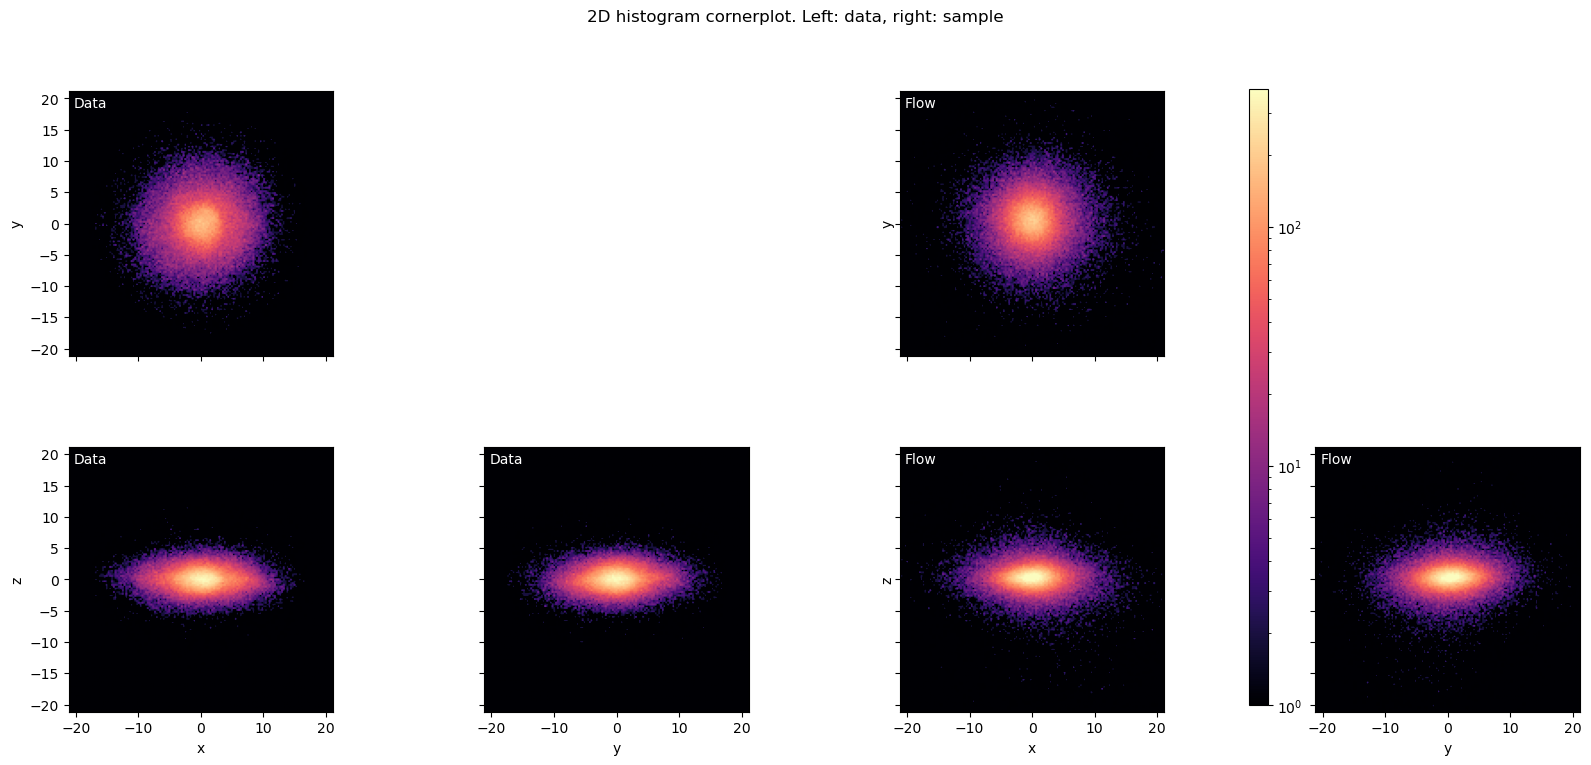

/export/home/ksampath/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


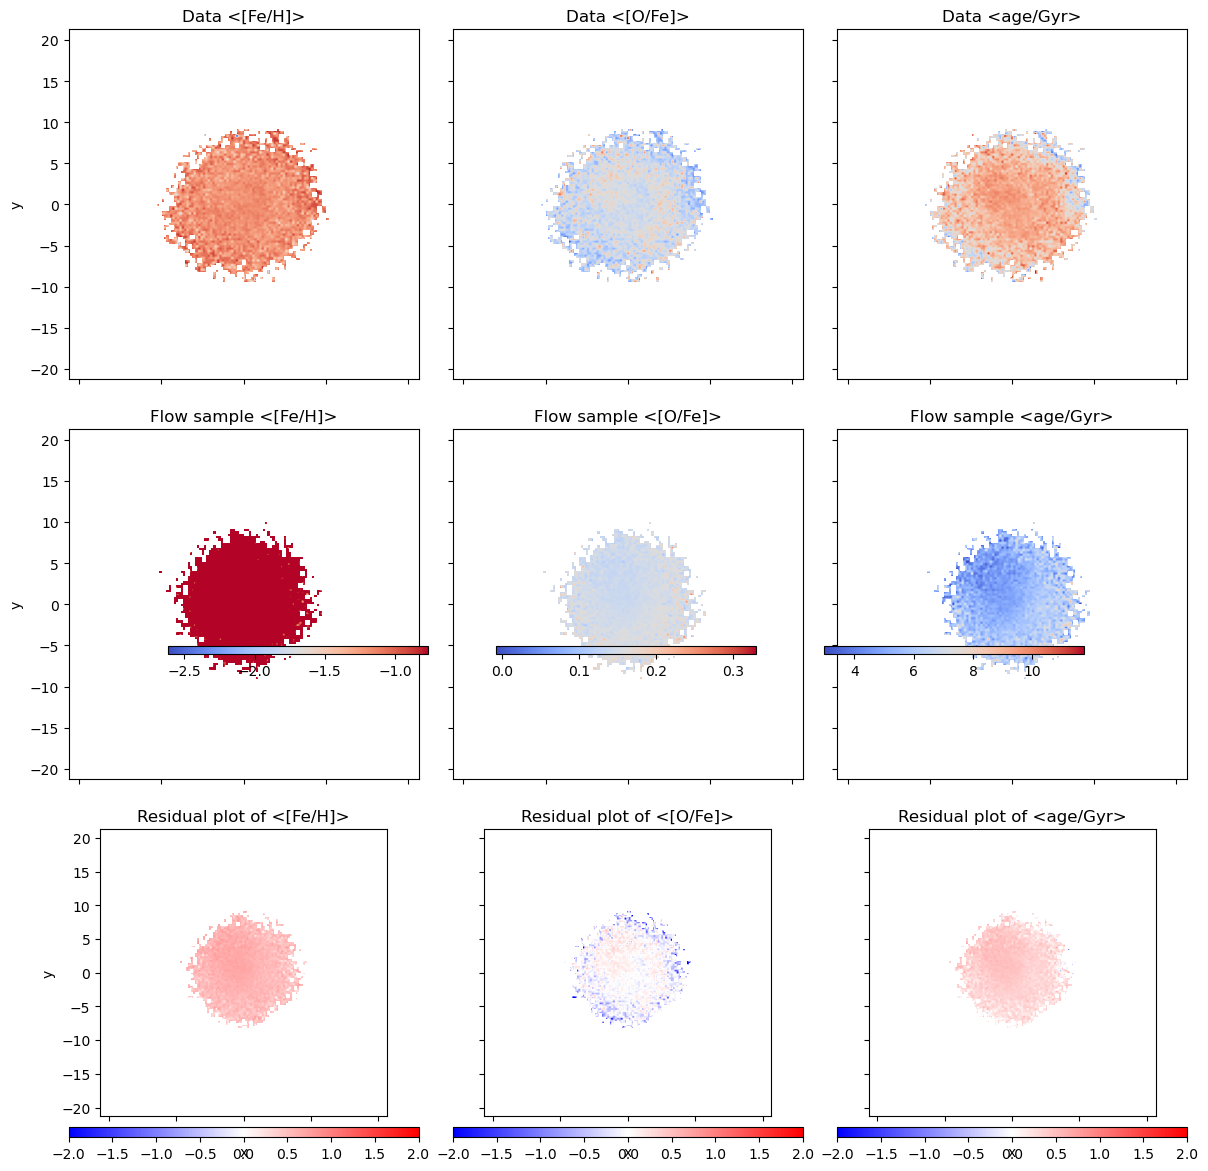

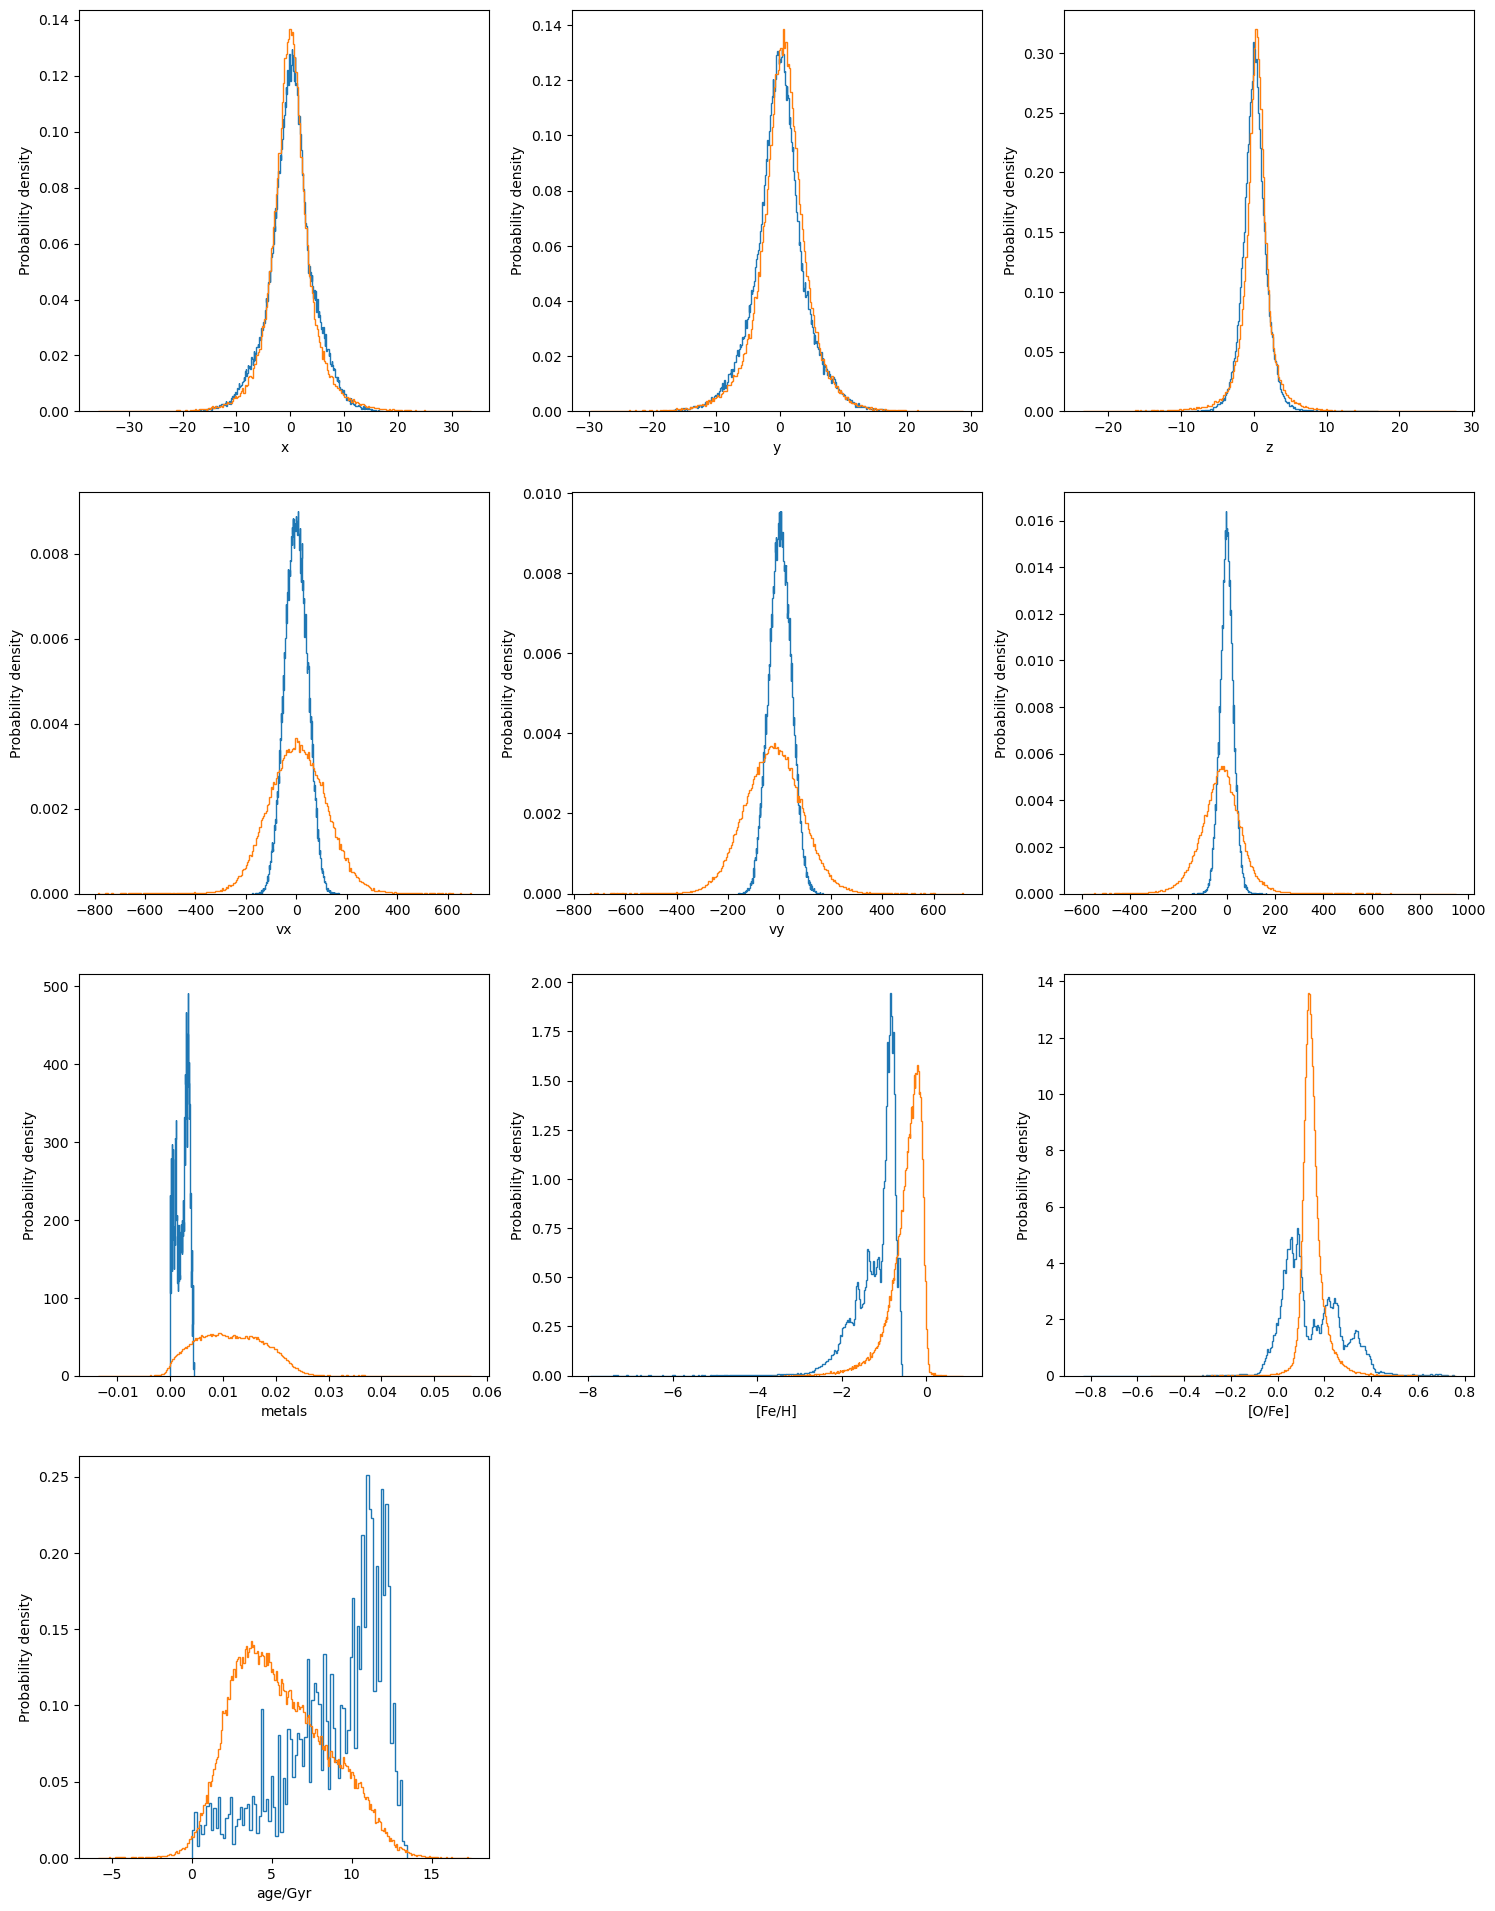

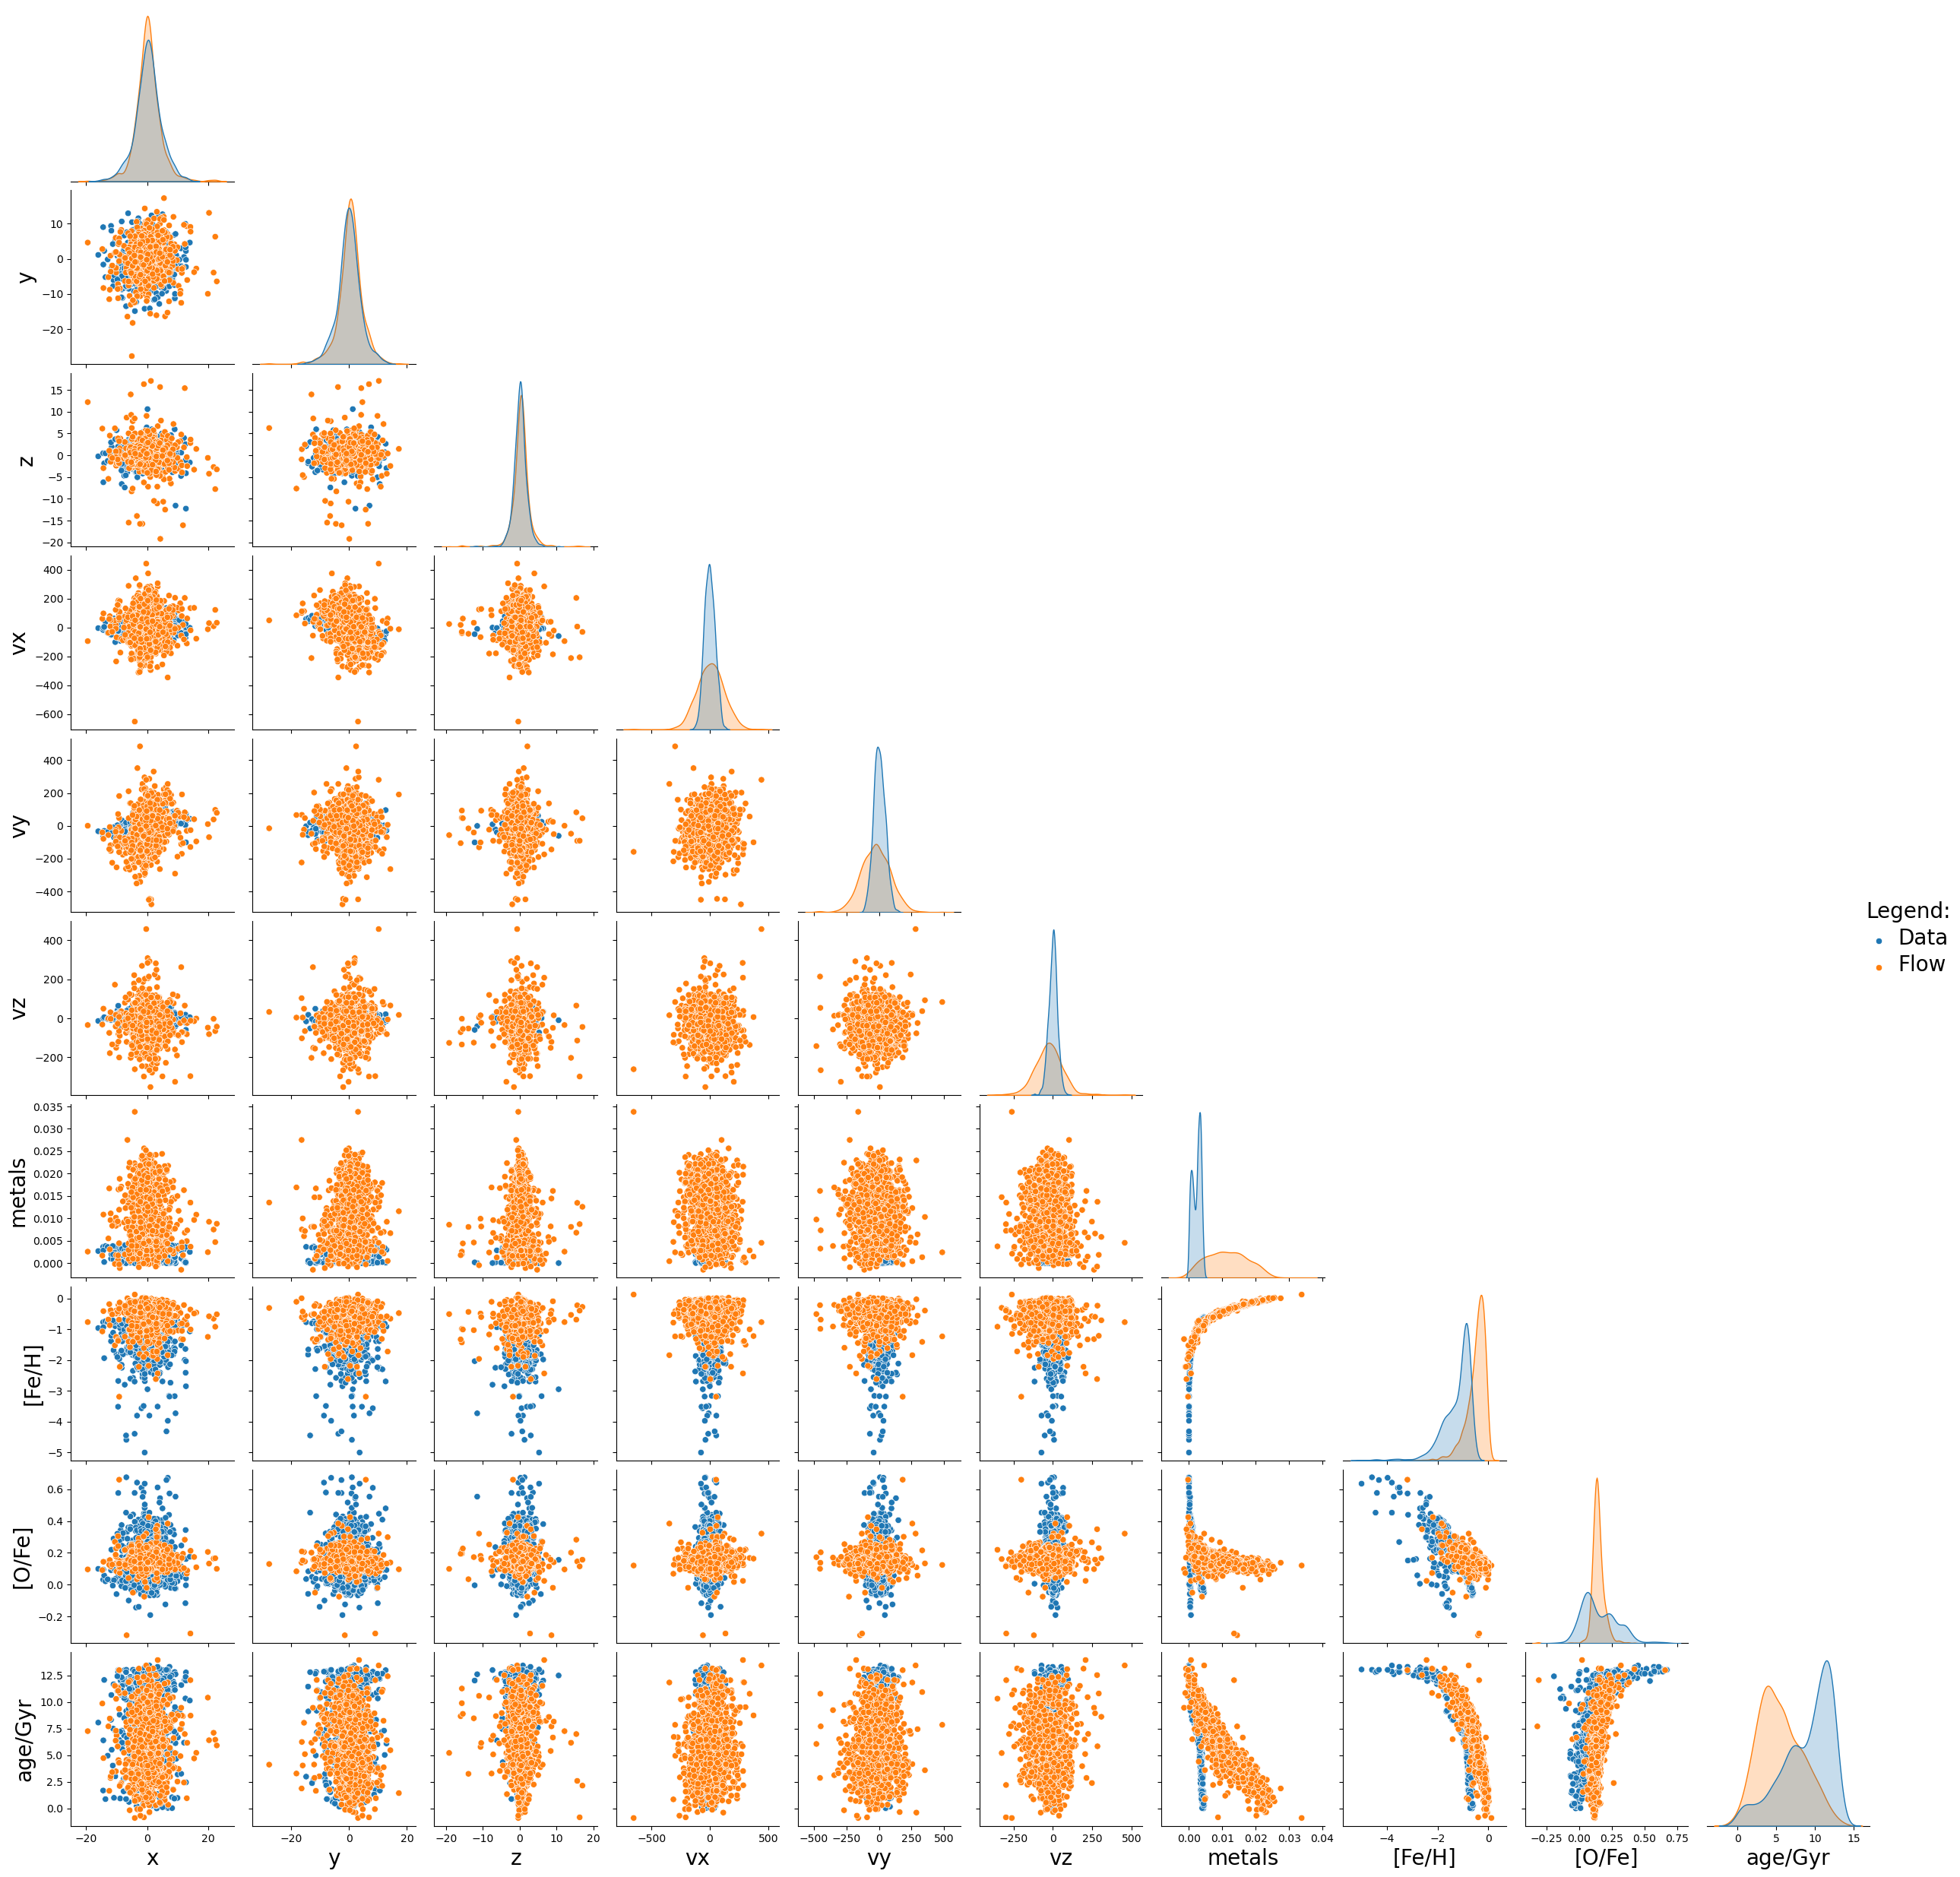

In [31]:
#Get comparison plot of single gal
get_result_plots(Galaxies[1], flow_sample[1], label=filename, format_="pdf")

In [28]:
#Also the pdf can be computed
#This automatically:
#1. Normalizes the points
#2. Computes the pdf
#3. Denormalizes the pdf i.e. respects the transformation_logdets
Points = mpc.diststack(Galaxies)
log_prob = mpc.log_prob(model, Points, split_size=int(6e5))
print(log_prob)

[-53.22609  -57.121017 -66.75448  ... -36.017628 -34.290676 -31.268383]
